In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/mESC`


In [1]:
using locaTE
using OptimalTransport
using NPZ
using StatsBase
using SparseArrays
using ProgressMeter
using Plots
using NearestNeighbors
using Graphs
using GraphSignals
using Printf
using Base.Threads
using LinearAlgebra
using DataFrames
using CSV
using Distances
using NNlib
using Discretizers
using EvalMetrics
using Random
using LaTeXStrings
# discretization length for AUPRC
Nq = 500
# plot sizes
PLT_CELL = 500
# figure directory
FIG_DIR = "."
# 
DATA_PATH="../../data/mESC/"

[ Info: Precompiling locaTE [d47a2e43-82e6-47ba-a340-eddb77145d33]


"../../data/mESC/"

In [2]:
# load logarithmized counts
X = npzread(string(DATA_PATH, "X.npy"))
X = relu.(X .- 1e-2);
# gene names
try
    global genes = Array(CSV.read(string(DATA_PATH, "genes.txt"), DataFrame)[:, 2])
catch e
    @info "Exception: $e"
    global genes = ["gene_$i" for i = 1:size(X, 2)];
end
# PCA coords, etc.
X_pca = npzread(string(DATA_PATH, "X_pca.npy"))
P = npzread(string(DATA_PATH, "P_statot.npy"))
C = npzread(string(DATA_PATH, "C.npy"))
dpt = npzread(string(DATA_PATH, "dpt.npy"));
# reference dataset
J = npzread(string(DATA_PATH, "J.npy"));
J[diagind(J)] .= 0;
J_escape = npzread(string(DATA_PATH,"J_ESCAPE.npy"));
J_escape[diagind(J_escape)] .= 0;

In [3]:
# neighbourhood kernel
R = npzread(string(DATA_PATH, "R.npy"))
# transition matrices
k = 1
Q = to_backward_kernel(P)
P_sp = sparse((P^k))
QT_sp = sparse((Q^k)')
R_sp = sparse(R);

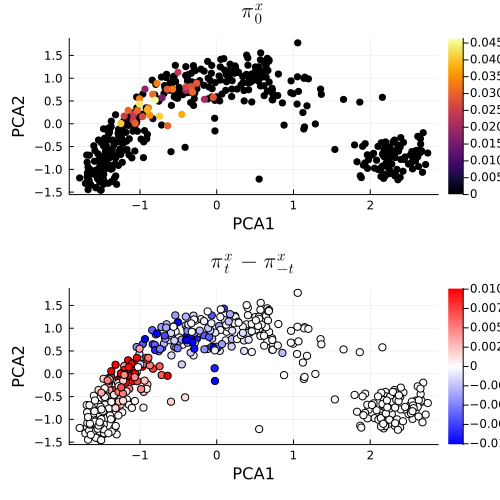

In [4]:
# visualise 
p0 = R[sortperm(dpt)[250], :]
plt=plot(scatter(X_pca[sortperm(p0), 1], X_pca[sortperm(p0), 2]; marker_z = sort(p0), markerstrokewidth = 0, alpha = 1.0, xlabel = "PCA1", ylabel = "PCA2", title = L"π_0^x"), 
    scatter(X_pca[:, 1], X_pca[:, 2]; marker_z = P_sp'*p0 - QT_sp*p0, color = :bwr, clim = (-0.0101, 0.0101), alpha = 1.0, xlabel = "PCA1", ylabel = "PCA2", title = L"\pi^x_{t} - \pi^x_{-t}"); legend = nothing, layout = (2, 1), size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "mESC_pca_densities.pdf"))
plt

In [5]:
TE = npzread("TE_locate.npy");
G = npzread("G_locate.npy");

In [6]:
A = reshape(maximum(G; dims = 1), size(X, 2), size(X, 2))
G_cdf = apply_cdf_norm(G, A);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


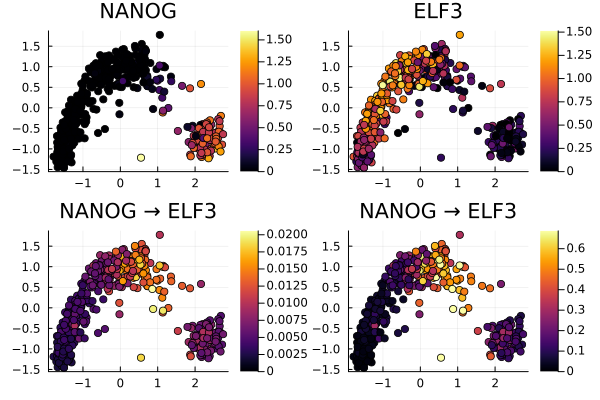

In [7]:
# g1 = "POU5F1"
g1 = "NANOG"
g2 = "ELF3"
plot(scatter(X_pca[:, 1], X_pca[:, 2], marker_z = X[:, findfirst(x -> x == g1, genes)], title = g1), 
    scatter(X_pca[:, 1], X_pca[:, 2], marker_z = X[:, findfirst(x -> x == g2, genes)], title = g2), 
    scatter(X_pca[:, 1], X_pca[:, 2], marker_z = reshape(G, :, size(X, 2), size(X, 2))[:, findfirst(x -> x == g1, genes), findfirst(x -> x == g2, genes)], 
        title = "$(g1) → $(g2)", clim = (0, quantile(vec(G[G .> 0]), 0.99))), 
    scatter(X_pca[:, 1], X_pca[:, 2], marker_z = reshape(G_cdf, :, size(X, 2), size(X, 2))[:, findfirst(x -> x == g1, genes), findfirst(x -> x == g2, genes)], 
        title = "$(g1) → $(g2)", clim = (0, quantile(vec(G_cdf[G_cdf .> 0]), 0.99))); legend = nothing)

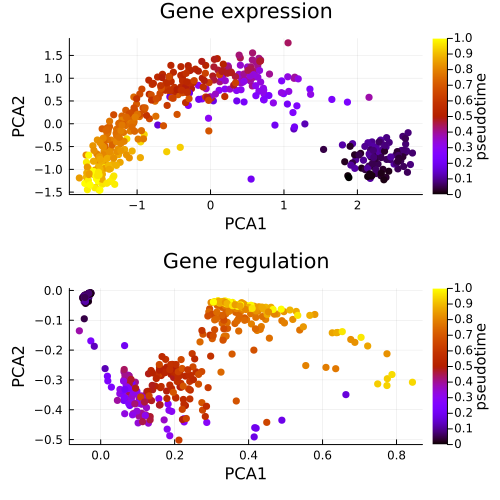

In [8]:
using MultivariateStats
M = fit(PCA, G'; maxoutdim = 3)
G_pca = (M.proj' * G')'
plt1=scatter(X_pca[:, 1], X_pca[:, 2], marker_z = dpt, color = :gnuplot, markerstrokewidth = 0, size = (PLT_CELL, PLT_CELL/2), xlabel = "PCA1", ylabel = "PCA2", colorbar_title = "pseudotime", title = "Gene expression", label = nothing)
plt2=scatter(G_pca[:, 1], G_pca[:, 2], marker_z = dpt, color = :gnuplot, markerstrokewidth = 0, size = (PLT_CELL, PLT_CELL/2), xlabel = "PCA1", ylabel = "PCA2", colorbar_title = "pseudotime", title = "Gene regulation", label = nothing)
plt=plot(plt1, plt2; size = (PLT_CELL, PLT_CELL), layout = (2, 1))
savefig(string(FIG_DIR, "mESC_pca_plots.pdf"))
plt

In [9]:
# NMF
using CUDA
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0
L = sparse(npzread("L_locate.npy"))

Random.seed!(0)
U, V, trace = fitnmf(cu(relu.(qnorm(TE, 0.9))),
                     [I(size(G, 1)), I(size(G, 2))], 1e-3*I + L,
                     cu(repeat(vec(Cg), 1, size(X, 1))'),
                     8; 
                     α = 10.0,
                     β = 0.0, 
              λ = [1, 1],
              μ = [1, 1],
              iter = 2_500, initialize = :nmf, print_iter = 100, dictionary = false, η = 1.0);
G_nmf = Array(U*V');
U = Array(U); V = Array(V);
# rescale U, V
# U .*= mean(V; dims = 1)
# V ./= mean(V; dims = 1);
V .*= maximum(U; dims = 1)
U ./= maximum(U; dims = 1);
# 
A = reshape(maximum(V'; dims = 1), size(X, 2), size(X, 2))
for i = 1:size(V, 2)
    x = reshape(V[:, i], size(X, 2), size(X, 2))
    V[:, i] .= vec(cdf_norm(x, A .+ 1e-9))
end
npzwrite("U.npy", U)
npzwrite("V.npy", V)

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


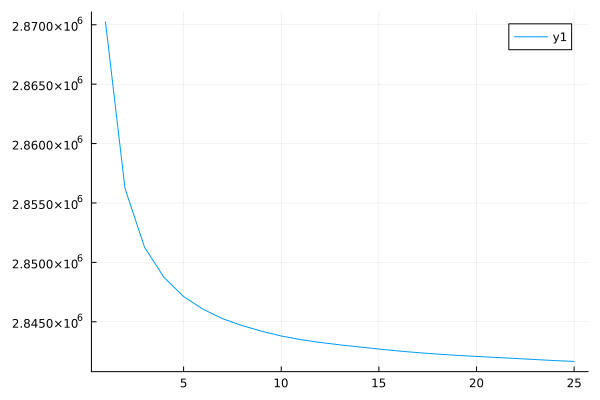

In [10]:
plot(trace)

In [11]:
# NTF
# Cg = cor(X).^2; Cg[diagind(Cg)] .= 0
# S, A, trace = fitntf(cu(reshape(qnorm(TE, 0.9), :, size(X, 2), size(X, 2))),
#                      [Array{Float32}(I(size(X, 1))), Array{Float32}(I(size(X, 2))), Array{Float32}(I(size(X, 2)))], Array{Float32}(1e-3*I + L), 
#                      cu(repeat(reshape(Cg, 1, size(X, 2), size(X, 2)), size(X, 1))), 
#                      [1, 1, 1],
#                      [1, 1, 1],
#                      10.0,
#                      0.0,
#                      32; iter = 2_500, dictionary = false, η = 1.0);

In [12]:
# ntf_atoms = [x*y' for (x, y) in zip(eachcol(A[2]), eachcol(A[3]))];
# A[1] .*= cu(mean.(ntf_atoms)')
# A[2] ./= cu(sqrt.(mean.(ntf_atoms))')
# A[3] ./= cu(sqrt.(mean.(ntf_atoms))')
# ntf_atoms ./= cu(mean.(ntf_atoms));

In [13]:
# for i = 1:length(A)
#     npzwrite("A_$i.npy", Array(A[i]))
# end

In [14]:
# plot(trace)

In [15]:
# comparisons
G_symm = locaTE.symm_row(G, size(X, 2));
J_symm = max.(J, J') .> 0.1;
J_symm_escape = locaTE.symm(J_escape);

# CeSpGRN: run first comparisons/cespgrn/run_cespgrn.ipynb
G_cespgrn = abs.(npzread("comparisons/cespgrn/G_cespgrn.npy"))
G_cespgrn[diagind(G_cespgrn)] .= 0;

# PIDC: run first comparisons/pidc/run_pidc.ipynb
G_pidc = npzread("comparisons/pidc/G_pidc.npy");

In [16]:
# GRISLI
CSV.write("comparisons/grisli/datamatrix.csv", DataFrame(X, :auto); header = false)
CSV.write("comparisons/grisli/dpt.csv", DataFrame(reshape(dpt, :, 1), :auto); header = false)
CSV.write("comparisons/grisli/J.csv", DataFrame(J, :auto); header = false);

# run first comparisons/grisli/main.m
G_grisli = (-1.0)*Array(CSV.read("comparisons/grisli/A_grisli_L_100.csv", DataFrame; header = false));

In [17]:
# TENET 
CSV.write("comparisons/tenet/X.csv", insertcols!(DataFrame(X, :auto), 1, :cell => collect(1:size(X, 1))); header = true)
CSV.write("comparisons/tenet/dpt.csv", DataFrame(reshape(dpt, :, 1), :auto); header = false)
CSV.write("comparisons/tenet/cellmask.csv", DataFrame(reshape(ones(Int, size(X, 1)), :, 1), :auto); header = false)

# run first comparisons/tenet/run_tenet.sh
G_tenet = CSV.read("comparisons/tenet/A_tenet_1.txt", DataFrame; header = true)
G_tenet = Array(G_tenet[:, 2:end]);

In [18]:
# SCODE
# run first comparisons/scode/run_scode.sh
G_scode = abs.(Matrix(CSV.read("comparisons/scode/SCODE_D_4/A.txt", DataFrame; header = false, type = Float64)));

┌ Warning: `type` keyword argument is deprecated; a single type can be passed to `types` instead
└ @ CSV ~/.julia/packages/CSV/OnldF/src/context.jl:356


In [19]:
# SINCERITIES
using XLSX
ld = LinearDiscretizer(binedges(DiscretizeUniformWidth(10), dpt))
dpt_bins = encode(ld, dpt)
XLSX.writetable("comparisons/SINCERITIES/X.xlsx", insertcols!(DataFrame(X, genes), size(X, 2)+1, :t => dpt_bins), overwrite =true)

In [20]:
df_sincerities = CSV.read("comparisons/SINCERITIES/A.txt", DataFrame)
G_sincerities = zero(G_scode)
for (source, target, score, _) in eachrow(df_sincerities)
    i = findall(genes .== source)[1]
    j = findall(genes .== target)[1]
    G_sincerities[i, j] = score
end

In [21]:
cdf_norm2(x) = cdf_norm(x, x .+ 1e-9)
agg_fun = x -> mean(x[dpt .< quantile(dpt, 0.9), :]; dims = 1)
# agg_fun = x -> maximum(x[dpt .< quantile(dpt, 0.9), :]; dims = 1)

#15 (generic function with 1 method)

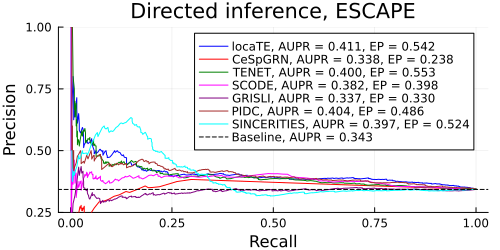

In [22]:
# compare to ESCAPE gold standard
regulators = vec(sum(J_escape; dims = 2) .> 0)
epfrac=0.1

plt1=plot(; title = "Directed inference, ESCAPE", legend = :topright, size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision", ylim = (0.25, 1.0))
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], cdf_norm2(reshape(agg_fun(G), size(X, 2), size(X, 2)))[regulators, :], 512)))
plot!(r, p; label = @sprintf("locaTE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2))[regulators, :], 512)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], G_tenet[regulators, :], 512)))
plot!(r, p; label = @sprintf("TENET, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :green)
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], G_scode[regulators, :], 512)))
plot!(r, p; label = @sprintf("SCODE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], G_grisli[regulators, :], 512)))
plot!(r, p; label = @sprintf("GRISLI, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :purple)
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], G_pidc[regulators, :], 512)))
plot!(r, p; label = @sprintf("PIDC, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :brown)
# rank-transform
rank_transform(A) = reshape(sortperm(sortperm(vec(A))), size(A)...)
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], rank_transform(G_sincerities[regulators, :]), 512)))
plot!(r, p; label = @sprintf("SINCERITIES, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :cyan)
hline!([mean(J_escape[regulators, :]), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J_escape[regulators, :])), color = :black, linestyle = :dash)
plt1

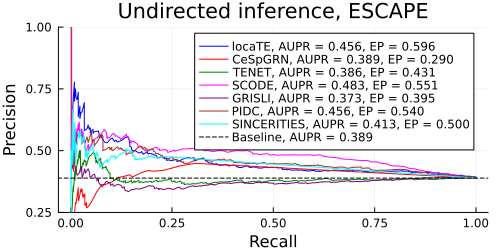

In [23]:
plt2=plot(; title = "Undirected inference, ESCAPE", legend = :topright, size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision", ylim = (0.25, 1.0))
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], cdf_norm2(reshape(agg_fun(locaTE.symm_row(G_symm, size(X, 2))), size(X, 2), size(X, 2)))[regulators, :], 512)))
plot!(r, p; label = @sprintf("locaTE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2))[regulators, :], 512)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], locaTE.symm(G_tenet)[regulators, :], 512)))
plot!(r, p; label = @sprintf("TENET, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :green)
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], locaTE.symm(G_scode)[regulators, :], 512)))
plot!(r, p; label = @sprintf("SCODE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], locaTE.symm(G_grisli)[regulators, :], 512)))
plot!(r, p; label = @sprintf("GRISLI, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :purple)
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], G_pidc[regulators, :], 512)))
plot!(r, p; label = @sprintf("PIDC, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :brown)
p, r = collect(eachcol(prec_rec_rate(J_symm_escape[regulators, :], locaTE.symm(G_sincerities)[regulators, :], 512)))
plot!(r, p; label = @sprintf("SINCERITIES, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :cyan)
hline!([mean(J_symm_escape[regulators, :]), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J_symm_escape[regulators, :])), color = :black, linestyle = :dash)
plt2

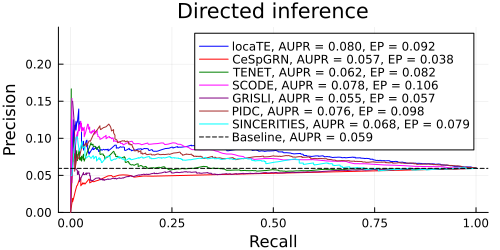

In [24]:
plt1=plot(; title = "Directed inference", legend = :topright, size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision", ylim = (0, 0.25))
p, r = collect(eachcol(prec_rec_rate(J, cdf_norm2(reshape(agg_fun(G), size(X, 2), size(X, 2))), 512)))
plot!(r, p; label = @sprintf("locaTE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
p, r = collect(eachcol(prec_rec_rate(J, reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2)), 512)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
p, r = collect(eachcol(prec_rec_rate(J, G_tenet, 512)))
plot!(r, p; label = @sprintf("TENET, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :green)
p, r = collect(eachcol(prec_rec_rate(J, G_scode, 512)))
plot!(r, p; label = @sprintf("SCODE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
p, r = collect(eachcol(prec_rec_rate(J, G_grisli, 512)))
plot!(r, p; label = @sprintf("GRISLI, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :purple)
p, r = collect(eachcol(prec_rec_rate(J, G_pidc, 512)))
plot!(r, p; label = @sprintf("PIDC, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :brown)
p, r = collect(eachcol(prec_rec_rate(J, rank_transform(G_sincerities), 512)))
plot!(r, p; label = @sprintf("SINCERITIES, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :cyan)
hline!([mean(J), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J)), color = :black, linestyle = :dash)
plt1

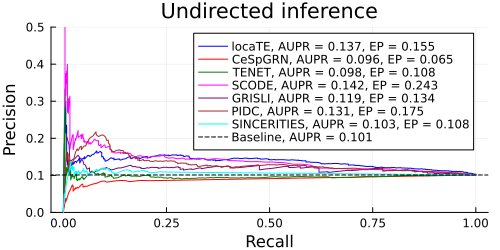

In [143]:
plt2=plot(; title = "Undirected inference", legend = :topright, size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision", ylim = (0, 0.5))
p, r = collect(eachcol(prec_rec_rate(J_symm, cdf_norm2(reshape(agg_fun(locaTE.symm_row(G_symm, size(X, 2))), size(X, 2), size(X, 2))), 512)))
plot!(r, p; label = @sprintf("locaTE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue)
p, r = collect(eachcol(prec_rec_rate(J_symm, reshape(agg_fun(G_cespgrn), size(X, 2), size(X, 2)), 512)))
plot!(r, p; label = @sprintf("CeSpGRN, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red)
p, r = collect(eachcol(prec_rec_rate(J_symm, locaTE.symm(G_tenet), 512)))
plot!(r, p; label = @sprintf("TENET, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :green)
p, r = collect(eachcol(prec_rec_rate(J_symm, locaTE.symm(G_scode), 512)))
plot!(r, p; label = @sprintf("SCODE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :magenta)
p, r = collect(eachcol(prec_rec_rate(J_symm, locaTE.symm(G_grisli), 512)))
plot!(r, p; label = @sprintf("GRISLI, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :purple)
p, r = collect(eachcol(prec_rec_rate(J_symm, G_pidc, 512)))
plot!(r, p; label = @sprintf("PIDC, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :brown)
p, r = collect(eachcol(prec_rec_rate(J_symm, locaTE.symm(G_sincerities), 512)))
plot!(r, p; label = @sprintf("SINCERITIES, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :cyan)
hline!([mean(J_symm), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J_symm)), color = :black, linestyle = :dash)
plt2

In [31]:
Int(round(size(X, 1)*0.9))

410

In [32]:
# Bootstrap
subsamp_idxs = [randperm(size(X, 1))[1:Int(round(0.9*size(X, 1)))] for _ = 1:5];
X_subsamp = [X[s, :] for s in subsamp_idxs];
row_norm(A) = A ./ sum(A; dims = 2)
P_sp_subsamp = [row_norm(P_sp[s, :][:, s]) for s in subsamp_idxs]
QT_sp_subsamp = [locaTE.to_backward_kernel(p) for p in P_sp_subsamp]
R_sp_subsamp = [row_norm(R_sp[s, :][:, s]) for s in subsamp_idxs];

In [33]:
TE_subsamp = [locaTE.estimate_TE(_X, 1:size(_X, 2), 1:size(_X, 2), _P, _Q, _R, wclr = true) for (_X, _P, _Q, _R) in zip(X_subsamp, P_sp_subsamp, QT_sp_subsamp, R_sp_subsamp)]

Progress: 100%|█████████████████████████████████████████| Time: 0:01:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


5-element Vector{Adjoint{Float64, Matrix{Float64}}}:
 [0.0 0.014511768924321806 … 5.789530424511357e-5 0.0; 0.0 0.0 … 0.00264340156936298 -0.0; … ; -0.0 0.0010893025840994482 … 0.0 0.0; 0.0 0.005595979643237221 … 3.895342186220972e-5 0.0]
 [0.0 0.0 … 0.00031492188203428823 0.0; -0.0 0.00011473696366263948 … 0.00015918785720371286 -0.0; … ; -0.0 0.0 … 0.0007125357778867803 0.0; 0.0 0.0 … 0.0009704306997426256 0.0]
 [0.0 0.001446053497176032 … 0.0008858028651088041 -0.0; 0.0 6.313252100355207e-6 … 0.00027232015325731823 0.0; … ; 0.0 0.0012163371146537642 … 0.010158009129512358 -0.0; 0.0 0.004302723924121687 … 0.0012721032329007578 -0.0]
 [0.0 0.0016831821013287636 … 0.003465663609282989 0.0; -0.0 0.011804486283566364 … 0.0 -0.0; … ; 0.0 0.0032812657775511747 … 0.0006400415424431759 0.0; 0.0 0.0006982910732831538 … 0.0 -0.0]
 [0.0 3.3420547504815256e-5 … 0.003939036975176137 0.0; 0.0 0.0033085528837166513 … 0.005842422985441918 0.0; … ; -0.0 0.005427261125447083 … 0.0 0.0; 0.0 0.0 … 0.001

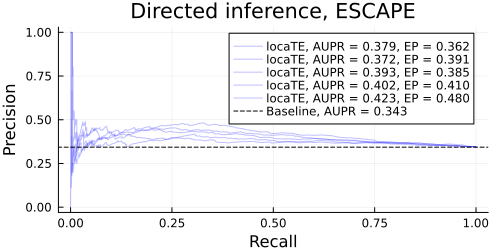

In [34]:
agg_fun2(x) = mean(x; dims =1)
regulators = vec(sum(J_escape; dims = 2) .> 0)
plt1=plot(; title = "Directed inference, ESCAPE", legend = :topright, size = (PLT_CELL, PLT_CELL/2), xlabel = "Recall", ylabel = "Precision")
for i = 1:length(TE_subsamp)
    p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], reshape(agg_fun2(TE_subsamp[i]), size(X, 2), size(X, 2))[regulators, :], 512)))
    plot!(r, p; label = @sprintf("locaTE, AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :blue, alpha = 0.25)
end
hline!([mean(J_escape[regulators, :]), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J_escape[regulators, :])), color = :black, linestyle = :dash)

In [35]:
TE = locaTE.estimate_TE(X, 1:size(X, 2), 1:size(X, 2), P_sp, QT_sp, R_sp, wclr = true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


In [36]:
diag_ind = vec(I(size(X, 2)));
cdf_norm2(x) = cdf_norm(x, x .+ 1e-9)
rank(x) = sortperm(sortperm(-x))
rank_score(x) = 1 ./ rank(x) .^ 2
A_ens = [rank_score(vec(agg_fun2(t))[.!diag_ind]) for t in TE_subsamp];
A = zeros(size(X, 2)*size(X, 2))
A[.!diag_ind] .= sum(A_ens);
rank_transform(A) = reshape(sortperm(sortperm(vec(A))), size(A)...)

rank_transform (generic function with 1 method)

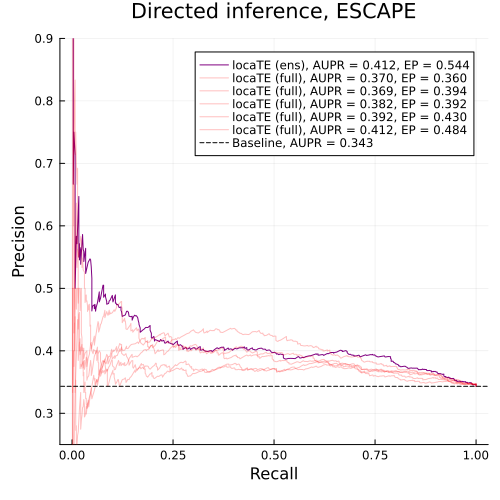

In [37]:
plt1=plot(; title = "Directed inference, ESCAPE", legend = :topright, size = (PLT_CELL, PLT_CELL), xlabel = "Recall", ylabel = "Precision", ylim = (0.25, 0.9))
p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], cdf_norm2(reshape(agg_fun2(TE), size(X, 2), size(X, 2)))[regulators, :], 512)))
plot!(r, p; label = @sprintf("locaTE (ens), AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :purple)
for i = 1:length(TE_subsamp)
    p, r = collect(eachcol(prec_rec_rate(J_escape[regulators, :], cdf_norm2(reshape(agg_fun2(TE_subsamp[i]), size(X, 2), size(X, 2)))[regulators, :], 512)))
    plot!(r, p; label = @sprintf("locaTE (full), AUPR = %0.3f, EP = %0.3f", aupr(p, r), ep(p, r; f = epfrac)), color = :red, alpha = 0.25)
end
hline!([mean(J_escape[regulators, :]), ]; label = @sprintf("Baseline, AUPR = %0.3f", mean(J_escape[regulators, :])), color = :black, linestyle = :dash)